In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#from dtaidistance import dtw

In [2]:
file_path = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/dataset/Versuch1_final.csv'
df = pd.read_csv(file_path, delimiter=';', decimal=',')

## Functions

In [3]:
def rename_columns(dataframe):
    renamed_columns = []
    for column in dataframe.columns:
        parts = column.split('_')
        if len(parts) >= 3:
            if parts[0] == 'Geschw':
                new_column = 'Speed_' + parts[1]
            elif parts[0] == 'Beschl':
                new_column = 'Accel_' + parts[1]
            elif parts[0] == 'Kraft':
                new_column = 'Power_' + parts[1]
            elif parts[0] == 'Current':
                new_column = 'Current_' + parts[1]
        else:
            new_column = column
        renamed_columns.append(new_column)
    
    dataframe.columns = renamed_columns
    return dataframe

In [4]:
def plot_prediction(y_test, y_pred, title):
    plt.figure(figsize=(16, 4))
    num_points = min(len(y_test), 10000)
    x_values = np.arange(num_points)
    plt.plot(x_values, y_test[:num_points], label='Actual Current', alpha=0.7)
    plt.plot(x_values, y_pred[:num_points], label='Predicted Current', alpha=0.5)
    plt.ylim(0, 30)  # Set y-axis limits from 0 to 30
    plt.xlabel('Index')
    plt.ylabel('Current')
    plt.title('Actual vs. Predicted Current -' + title)
    plt.legend()
    plt.show()


In [5]:
def dtw_distbance(y_test, y_pred):
    predicted = np.array(y_pred)
    actual = np.array(y_test)
    distance = dtw.distance(predicted, actual)
    print(f"DTW Distance: {distance}")

In [59]:
def fit_predict(model, X_train, X_test, y_train, y_test, title):
    import os
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #print(y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    #dtw_dist = dtw_distbance(y_test, y_pred)

    print("Mean Absolute Error:", mae)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", np.sqrt(mse))
    print("R-squared Score:", r2)
    print("Mean Absolute Percentage Error:", mape)
    #print("DTW Distance:", dtw_dist)

    plot_prediction(y_test, y_pred, title)
    targets = pd.DataFrame({'Test':y_test, 'Predicted':y_pred})
    output_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/fulldata'

    filename = os.path.join(output_folder, f'True_Predicted.csv')
    targets.to_csv(filename, index=False)
    #return y_pred
    #residual_analysis(y_test, y_pred)

## Pre-processing and Data Split

In [7]:
df.drop('removed_material_0', axis=1, inplace=True)
df = rename_columns(df)

In [11]:
df = df.iloc[:136350,:]

In [12]:
df.shape

(136350, 16)

In [81]:
X = df.drop(columns=['Current_X', 'Current_Y', 'Current_Z', 'Current_SP'])
y = df[['Current_X', 'Current_Y', 'Current_Z', 'Current_SP']].sum(axis=1)
split_index = int(0.5 * len(df))

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]
#X_train.loc[:, 'Current'] = y_train


# Baseline Model

## Random Forest Regressor

Mean Absolute Error: 0.09710207936860948
Mean Squared Error: 0.17268473352481475
Root Mean Squared Error: 0.41555352666631856
R-squared Score: 0.8012092552671899
Mean Absolute Percentage Error: 1.529278878218889


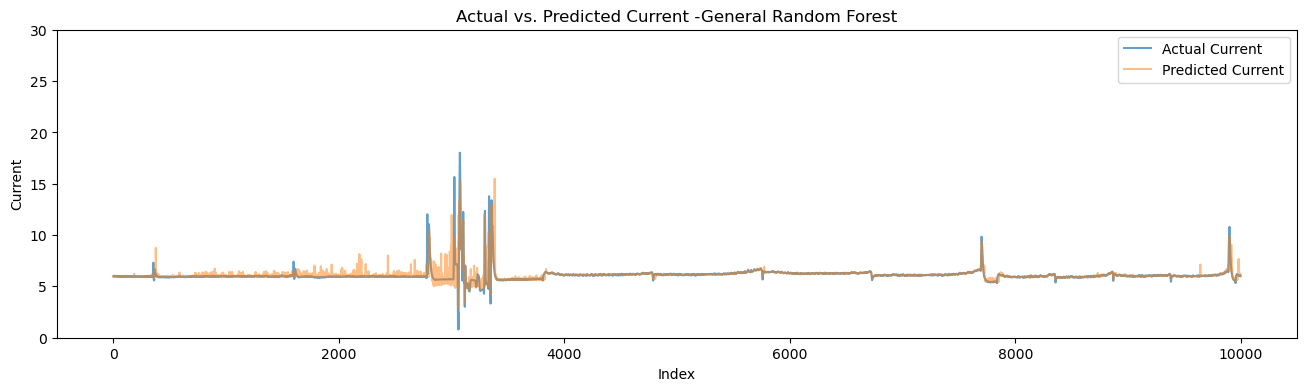

In [88]:
rf_model = RandomForestRegressor()
fit_predict(rf_model, X_train, X_test, y_train, y_test, 'General Random Forest')

### Parameter Optimization

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint


n_estimators = [int(x) for x in np.linspace(start = 5, stop = 100, num = 5)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 4)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 40, 70, 100, None],
 'max_features': ['log2', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [5, 28, 52, 76, 100]}


In [16]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 12, cv = 3, verbose=2, random_state=3939, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=28; total time=  30.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=28; total time=  30.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=28; total time=  31.5s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 1.3min
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=52; total time= 1.7min
[CV] END bootstrap=True, max_depth=40, max_fe

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=12,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 40, 70, 100, None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [5, 28, 52, 76, 100]},
                   random_state=3939, verbose=2)

In [17]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': False}

Mean Absolute Error: 0.5271995742064514
Mean Squared Error: 1.4409983433095808
Root Mean Squared Error: 1.2004159043054956
R-squared Score: -0.0974267931486188
Mean Absolute Percentage Error: 8.393717434255816


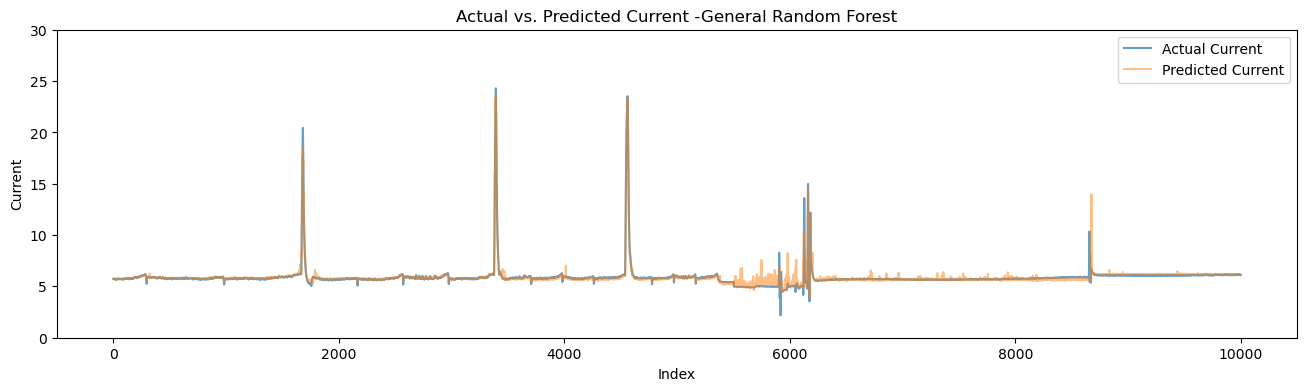

In [18]:
best_random = rf_random.best_estimator_
fit_predict(best_random, X_train, X_test, y_train, y_test, 'General Random Forest')

In [26]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [False],
    'max_depth': [35, 40, 45, 50],
    'max_features': ['sqrt'],
    'min_samples_leaf': [2],
    'min_samples_split': [5],
    'n_estimators': [90, 100, 110, 120],
    'random_state': [3939]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [27]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version

[CV] END bootstrap=False, max_depth=35, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=90, random_state=3939; total time= 4.3min
[CV] END bootstrap=False, max_depth=35, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=90, random_state=3939; total time= 4.3min
[CV] END bootstrap=False, max_depth=35, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=90, random_state=3939; total time= 4.4min
[CV] END bootstrap=False, max_depth=35, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=3939; total time= 4.8min
[CV] END bootstrap=False, max_depth=35, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=3939; total time= 4.9min
[CV] END bootstrap=False, max_depth=35, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=3939; total time= 4.9min
[CV] END bootstrap=False, max_depth=35, max_features=sqrt, min_samp

{'bootstrap': False,
 'max_depth': 35,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 110,
 'random_state': 3939}

Mean Absolute Error: 0.5346107777225857
Mean Squared Error: 1.4608698733669843
Root Mean Squared Error: 1.20866449992005
R-squared Score: -0.112560432688944
Mean Absolute Percentage Error: 8.520808497967082


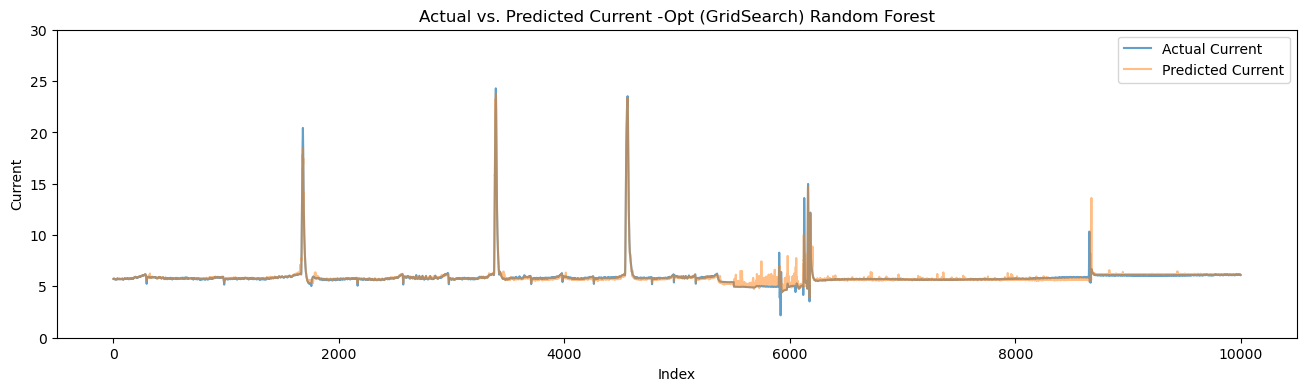

In [28]:
best_grid = grid_search.best_estimator_
fit_predict(best_grid, X_train, X_test, y_train, y_test, 'Opt (GridSearch) Random Forest')

# Peak Detection

In [17]:
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(len(y)):
        threshold = np.mean(y[i-lag:i])
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

In [44]:
def detect_peaks(y, lag, t):
    peaks = []
    threshold = np.mean(y[:lag])
    for i in range(len(y)):
        if y[i] > threshold*t:
            peaks.append(i)
        threshold = np.mean(y[i:lag+i])
    return peaks


In [45]:
def get_peak_indices_by_column(dataframe, lag, t):
    peak_indices_by_column = {}

    for column_name in dataframe.columns:
        result = detect_peaks(dataframe[column_name], lag, t)
        #peak_indices = [i for i in enumerate(result)]
        peak_indices_by_column[column_name] = result

    return peak_indices_by_column

In [46]:
import itertools

def find_common_peaks(peaks_df):
    common_peaks = []
    
    columns = peaks_df['Column_Name'].tolist()
    columns.remove('Current')
    column_combinations = [(column, 'Current') for column in columns]   

    for pair in column_combinations:
        column1_peaks = set(peaks_df.loc[peaks_df['Column_Name'] == pair[0], 'Peak_Indices'].iloc[0])
        column2_peaks = set(peaks_df.loc[peaks_df['Column_Name'] == pair[1], 'Peak_Indices'].iloc[0])
        
        common_indices = list(column1_peaks.intersection(column2_peaks))
        num_common_peaks = len(common_indices)
        
        common_peaks.append({'feature_pair': pair, 'num_peaks': num_common_peaks, 'lag':peaks_df['Lag'].iloc[0], 'thresh':peaks_df['Threshold'].iloc[0] ,'peak_indices': common_indices,})
    
    return pd.DataFrame(common_peaks)

In [47]:
def plot_common_peaks(df, common_peaks_df, lag):
    for index, row in common_peaks_df.iterrows():
        pair = row['feature_pair']
        common_indices = sorted(row['peak_indices'])
        
        values_column1 = []
        index_column = []
        values_column2 = []
        
        for index_value in common_indices:
            # Extract values for both columns from 10 indices before and after the common index
            values_column1.extend(df.loc[index_value - 10:index_value + 10, pair[0]].tolist())
            values_column2.extend(df.loc[index_value - 10:index_value + 10, pair[1]].tolist())
            if index_value > 10:
                index_column.extend(list(range(index_value - 10, index_value + 11)))
                
        #values_column1 = (values_column1 - np.min(values_column1)) / (np.max(values_column1) - np.min(values_column1))
        #values_column2 = (values_column2 - np.min(values_column2)) / (np.max(values_column2) - np.min(values_column2))
        values_column1 = [(value - np.min(values_column1)) / (np.max(values_column1) - np.min(values_column1)) for value in values_column1]
        values_column2 = [(value - np.min(values_column2)) / (np.max(values_column2) - np.min(values_column2)) * (2 - 1) + 1 for value in values_column2]
        plt.figure(figsize=(12, 4))
        plt.plot(index_column, values_column1, label=pair[0])
        plt.plot(index_column, values_column2, label=pair[1])
    
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.title('Common Peaks --' + str(row['num_peaks']) +' (Lag = ' + str(lag) + ')')
        plt.legend()
        plt.show()


In [48]:
def get_output_peaks(df, lag, t):  
    peak_info = get_peak_indices_by_column(df, lag, t)
    peaks_df = pd.DataFrame({'Column_Name': list(peak_info.keys()), 
                                'Peak_Indices': list(peak_info.values())})
    peaks_df['Num_Peaks'] = peaks_df['Peak_Indices'].apply(len)
    peaks_df['Lag'] = lag
    peaks_df['Threshold'] = t
    peaks_df = peaks_df[~peaks_df['Column_Name'].str.startswith('Power')]
    #print(peaks_df.head(10))

    common_peaks_df = find_common_peaks(peaks_df)
    #plot_common_peaks(df, common_peaks_df, lag, t)
    #print(common_peaks_df)

    return common_peaks_df


In [78]:
df_p = pd.DataFrame()
X_train.loc[:, 'Current'] = y_train
lag = [500]
th = [1.1]
for lag_val in lag:
    for t in th:
        com_pk_df = get_output_peaks(X_train, lag_val, t)
        df_p = df_p.append(com_pk_df)

import os
output_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/fulldata'

filename = os.path.join(output_folder, f'common_peaks_50%_reduced_t10.csv')
df_p.to_csv(filename, index=False)

In [39]:
print(df_p)

          feature_pair  num_peaks   lag  thresh  \
0   (Speed_X, Current)        385  1000     1.1   
1   (Speed_Y, Current)        358  1000     1.1   
2   (Speed_Z, Current)        473  1000     1.1   
3  (Speed_SP, Current)        101  1000     1.1   
4   (Accel_X, Current)        382  1000     1.1   
5   (Accel_Y, Current)        445  1000     1.1   
6   (Accel_Z, Current)        419  1000     1.1   
7  (Accel_SP, Current)        218  1000     1.1   
0   (Speed_X, Current)        255  1000     1.3   
1   (Speed_Y, Current)        228  1000     1.3   
2   (Speed_Z, Current)        275  1000     1.3   
3  (Speed_SP, Current)         76  1000     1.3   
4   (Accel_X, Current)        195  1000     1.3   
5   (Accel_Y, Current)        253  1000     1.3   
6   (Accel_Z, Current)        229  1000     1.3   
7  (Accel_SP, Current)        124  1000     1.3   
0   (Speed_X, Current)        427   500     1.1   
1   (Speed_Y, Current)        439   500     1.1   
2   (Speed_Z, Current)        4

# Peak Aware Model

We have chosen lag = 10000 and influence = 0.1 as the parameters for the peak detection methods. Based on this, separate peaks and non-peaks into two different dfs.

In [79]:
peak_info = pd.read_csv('/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/fulldata/common_peaks_50%_reduced_t10.csv')
print(peak_info)

              feature_pair  num_peaks  lag  thresh  \
0   ('Speed_X', 'Current')        574  500     1.1   
1   ('Speed_Y', 'Current')        652  500     1.1   
2   ('Speed_Z', 'Current')        634  500     1.1   
3  ('Speed_SP', 'Current')        134  500     1.1   
4   ('Accel_X', 'Current')        512  500     1.1   
5   ('Accel_Y', 'Current')        541  500     1.1   
6   ('Accel_Z', 'Current')        565  500     1.1   
7  ('Accel_SP', 'Current')        329  500     1.1   

                                        peak_indices  
0  [49166, 49167, 49168, 49169, 49170, 49171, 491...  
1  [34867, 34868, 34869, 34870, 34871, 34872, 348...  
2  [34826, 34827, 34828, 34829, 34830, 34831, 348...  
3  [34304, 34305, 56940, 56941, 56942, 56943, 569...  
4  [34826, 49166, 49167, 49168, 49169, 49170, 491...  
5  [34826, 34827, 34828, 34829, 34830, 49167, 491...  
6  [34827, 34829, 34831, 34832, 34833, 49170, 491...  
7  [59433, 59434, 59438, 59439, 59440, 59443, 594...  


In [80]:
max_peaks = peak_info[peak_info['num_peaks'] == peak_info['num_peaks'].max()]
print(max_peaks)

             feature_pair  num_peaks  lag  thresh  \
1  ('Speed_Y', 'Current')        652  500     1.1   

                                        peak_indices  
1  [34867, 34868, 34869, 34870, 34871, 34872, 348...  


Check if many features have common peaks or only one.

In [51]:
peak_indices_lists = max_peaks['peak_indices'].tolist()
all_indices_same = all(peak_indices == peak_indices_lists[0] for peak_indices in peak_indices_lists)
same = 0
if all_indices_same:
    same = 1
    print("All peak indices are the same across all rows.")
else:
    print("Peak indices are not the same across all rows.")


All peak indices are the same across all rows.


Based on that, create two dfs for peaks and non-peaks considering the selected feature(s).

In [72]:
column_name = eval(max_peaks['feature_pair'].iloc[0])[0]

In [82]:
def create_train_test_split(X_train, y_train, X_test, y_test, column_name):
    result = detect_peaks(X_train[column_name], 500,1.1)
    peak_indices_train = result

    X_train_peak = X_train.loc[peak_indices_train]
    y_train_peak = y_train.loc[peak_indices_train]
    X_train_non_peak = X_train.drop(peak_indices_train)
    y_train_non_peak = y_train.drop(peak_indices_train)

    #Find peaks and non-peaks in test data
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    result = detect_peaks(X_test[column_name], 500,1.1)
    peak_indices_test = result

    X_test_peak = X_test.loc[peak_indices_test]
    y_test_peak = y_test.loc[peak_indices_test]
    X_test_non_peak = X_test.drop(peak_indices_test)
    y_test_non_peak = y_test.drop(peak_indices_test)

    return X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak

## Whole dataset using column with Max Common Peaks

In [83]:
X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak = create_train_test_split(X_train, y_train, X_test, y_test, column_name)

Build and train a Random Forest Regressor and Neural Network model for non-peak data

Mean Absolute Error: 0.09608940061840644
Mean Squared Error: 0.2002070613958434
Root Mean Squared Error: 0.44744503729044016
R-squared Score: 0.7306607578700213
Mean Absolute Percentage Error: 1.368887322484407


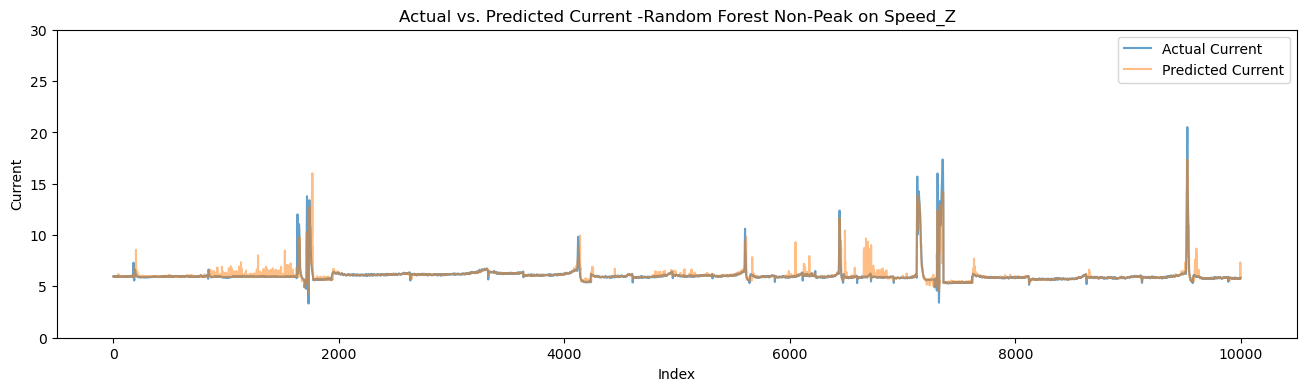

In [87]:
fit_predict(rf_model, X_train_non_peak, X_test_non_peak, y_train_non_peak, y_test_non_peak, 'Random Forest Non-Peak on '+ column_name)

Build and train a RF and NN model for peak data

Mean Absolute Error: 0.13436976251279306
Mean Squared Error: 0.3370028417147847
Root Mean Squared Error: 0.5805194585152031
R-squared Score: 0.6747665907906799
Mean Absolute Percentage Error: 2.1672022247703553


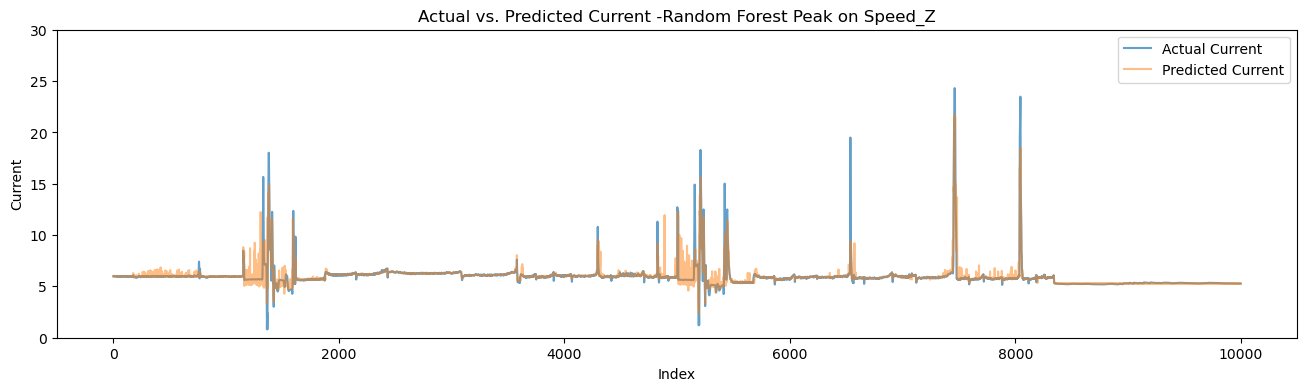

In [86]:
fit_predict(rf_model, X_train_peak, X_test_peak, y_train_peak, y_test_peak, 'Random Forest Peak on '+ column_name)

In [ ]:
y_test_peak, 

## Without using Global Models

Mean Absolute Error: 0.09048353246663692
Mean Squared Error: 0.19577784453151775
Root Mean Squared Error: 0.4424679022613027
R-squared Score: 0.8291813321380505
Mean Absolute Percentage Error: 1.4185122053495336


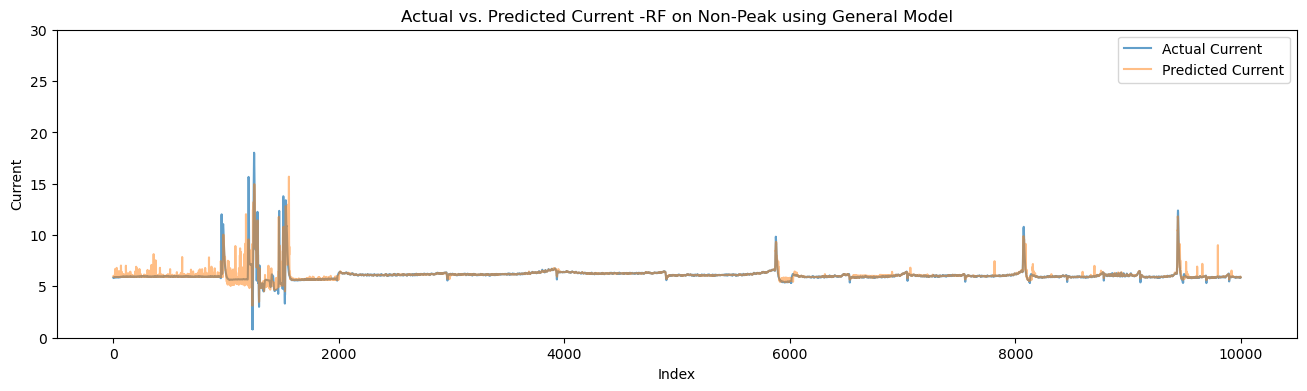

In [52]:
fit_predict(rf_model, X_train, X_test_non_peak, y_train, y_test_non_peak, 'RF on Non-Peak using General Model')

Mean Absolute Error: 0.11367341254481
Mean Squared Error: 0.23319627317947186
Root Mean Squared Error: 0.4829039999621787
R-squared Score: 0.7965332756103776
Mean Absolute Percentage Error: 1.7316185139922158


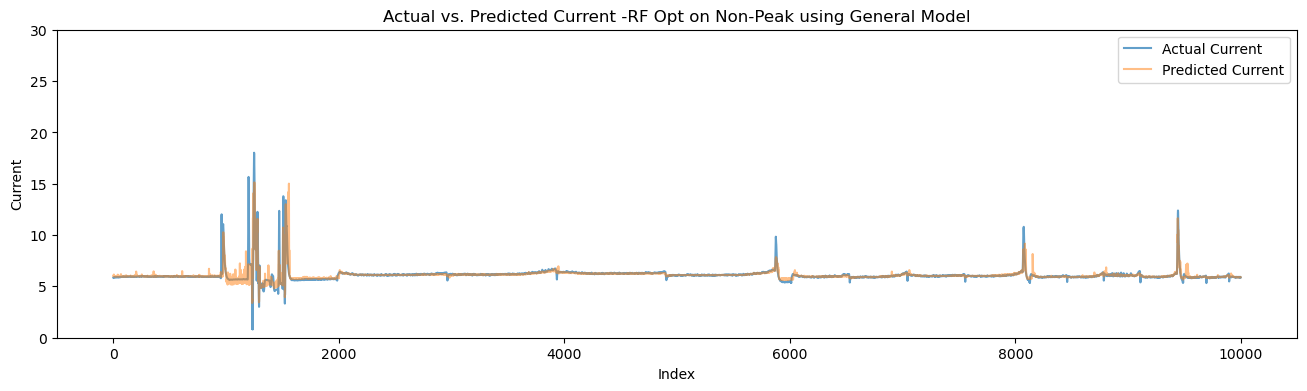

In [53]:
fit_predict(best_grid, X_train, X_test_non_peak, y_train, y_test_non_peak, 'RF Opt on Non-Peak using General Model')

d:\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean Absolute Error: 0.24045596072353048
Mean Squared Error: 0.7229464947779037
Root Mean Squared Error: 0.8502626034219686
R-squared Score: 0.21919714016874847
Mean Absolute Percentage Error: 3.653217143100046


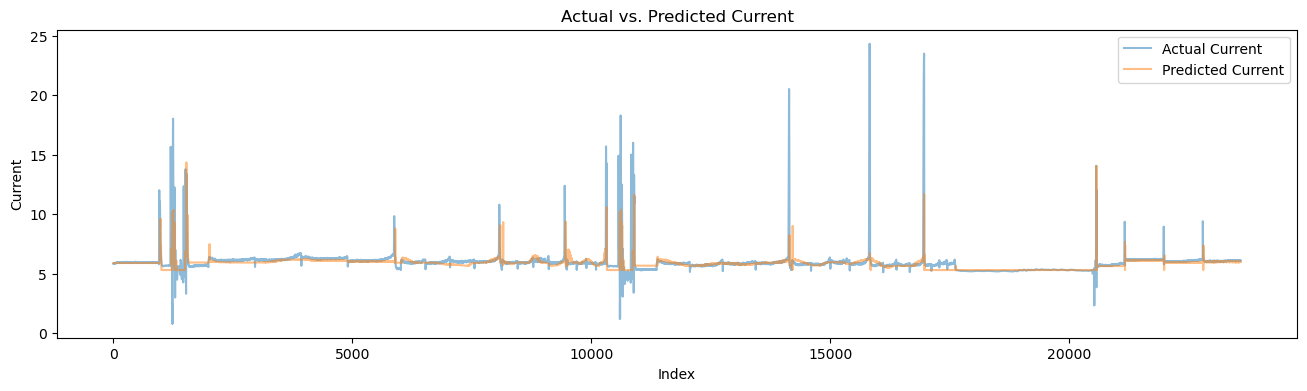

In [123]:
neural_nets(X_train, X_test_non_peak, y_train, y_test_non_peak)

General model for non-peak data and Peak-aware model for peak data

| Model                   |  MAE  |  MSE  |  RMSE |   R2  | MAPE  |
|-------------------------|-------|-------|-------|-------|-------|
| General Random Forest   | 0.101 | 0.195 | 0.442 | 0.800 | 1.586 |
| General Neural Network  | 0.269 | 0.782 | 0.884 | 0.199 | 3.975 |
|                         |       |       |       |       |       |
| Gen Non-Peak RF         | 0.092 | 0.186 | 0.431 | 0.798 | 1.463 |
| Gen Non-Peak NN         | 0.240 | 0.722 | 0.850 | 0.219 | 3.653 |
|                         |       |       |       |       |       |
| Peak-Aware RF           | 0.108 | 0.191 | 0.437 | 0.841 | 1.720 |
| Peak-Aware NN           | 0.267 | 0.905 | 0.951 | 0.250 | 3.829 |

## Using only one feature as dataset

In [54]:
X_train_f1 = X_train[[column_name]].copy()
X_test_f1 = X_test[[column_name]].copy()

X_train_peak_f1, y_train_peak_f1, X_train_non_peak_f1, y_train_non_peak_f1, X_test_peak_f1, y_test_peak_f1, X_test_non_peak_f1, y_test_non_peak_f1 = create_train_test_split(X_train_f1, y_train, X_test_f1, y_test, column_name)

Mean Absolute Error: 0.3652310717426718
Mean Squared Error: 0.9397565910632965
Root Mean Squared Error: 0.9694104347815204
R-squared Score: 0.038929734540576466
Mean Absolute Percentage Error: 5.686207691985812


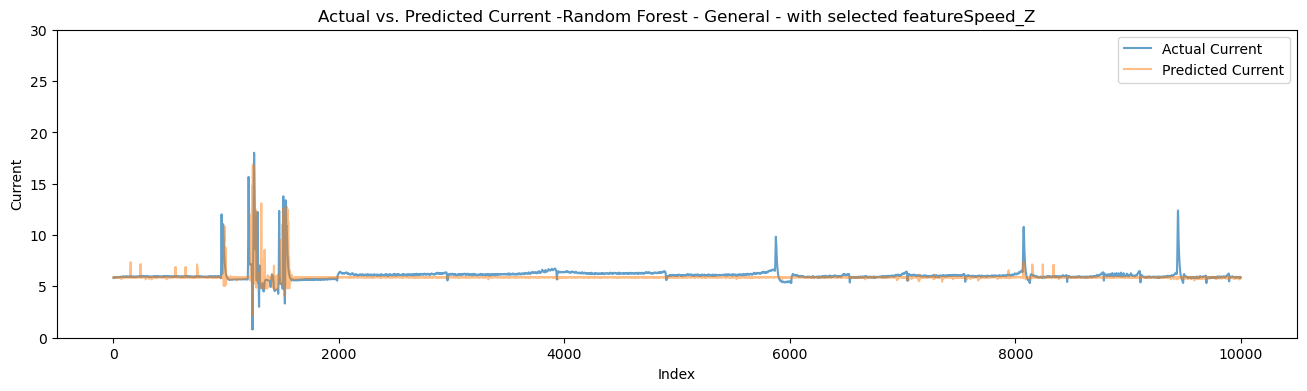

In [55]:
fit_predict(rf_model, X_train_f1, X_test_f1, y_train, y_test, 'Random Forest - General - with selected feature' + column_name)

Mean Absolute Error: 0.3690222187980235
Mean Squared Error: 1.026684147707714
Root Mean Squared Error: 1.0132542364617647
R-squared Score: -0.04996933861778596
Mean Absolute Percentage Error: 5.733255782577777


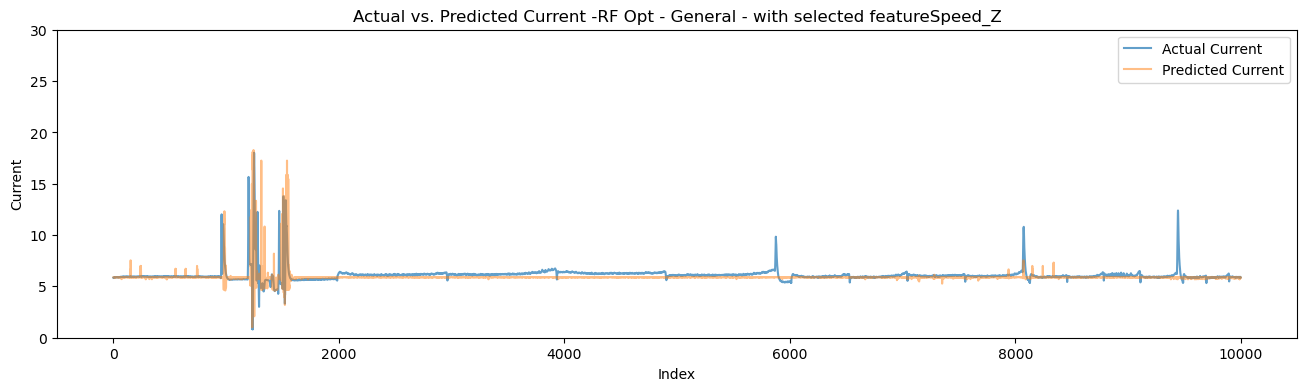

In [56]:
fit_predict(best_grid, X_train_f1, X_test_f1, y_train, y_test, 'RF Opt - General - with selected feature' + column_name)

Mean Absolute Error: 0.35128518875265974
Mean Squared Error: 1.0786442127302214
Root Mean Squared Error: 1.038577976239734
R-squared Score: 0.05886915878310517
Mean Absolute Percentage Error: 5.362292919525219


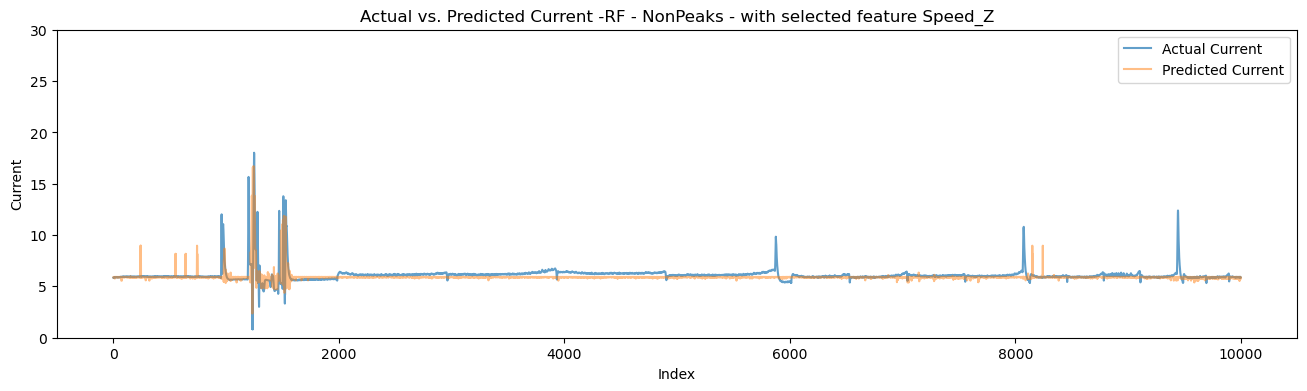

In [57]:
fit_predict(rf_model, X_train_non_peak_f1, X_test_non_peak_f1, y_train_non_peak_f1, y_test_non_peak_f1, 'RF - NonPeaks - with selected feature ' + column_name)

Mean Absolute Error: 0.3547413510842273
Mean Squared Error: 1.1686394645836546
Root Mean Squared Error: 1.0810362919826766
R-squared Score: -0.019652846974442584
Mean Absolute Percentage Error: 5.4144059820899475


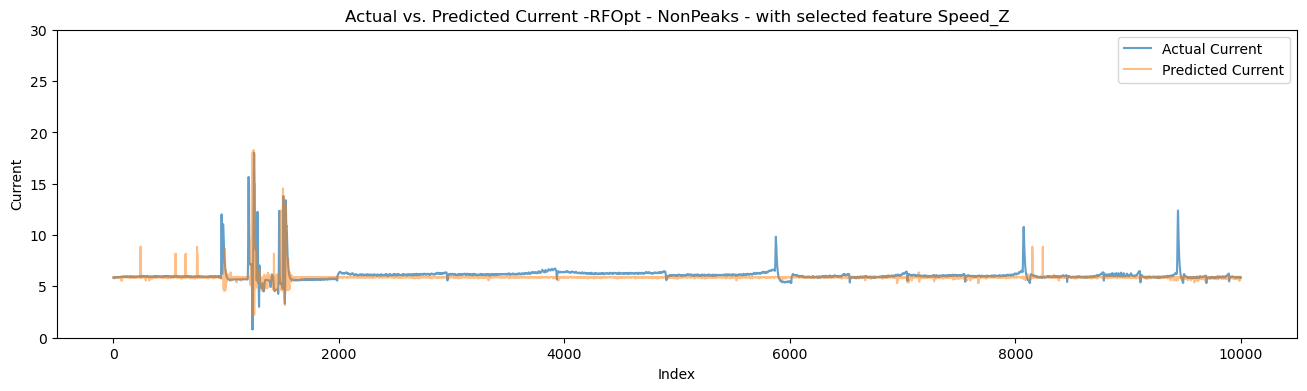

In [58]:
fit_predict(best_grid, X_train_non_peak_f1, X_test_non_peak_f1, y_train_non_peak_f1, y_test_non_peak_f1, 'RFOpt - NonPeaks - with selected feature ' + column_name)

d:\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean Absolute Error: 3.0202598946286945
Mean Squared Error: 1561.2358326703845
Root Mean Squared Error: 39.51247692400952
R-squared Score: -3292.471847413222
Mean Absolute Percentage Error: 62.8484386793107


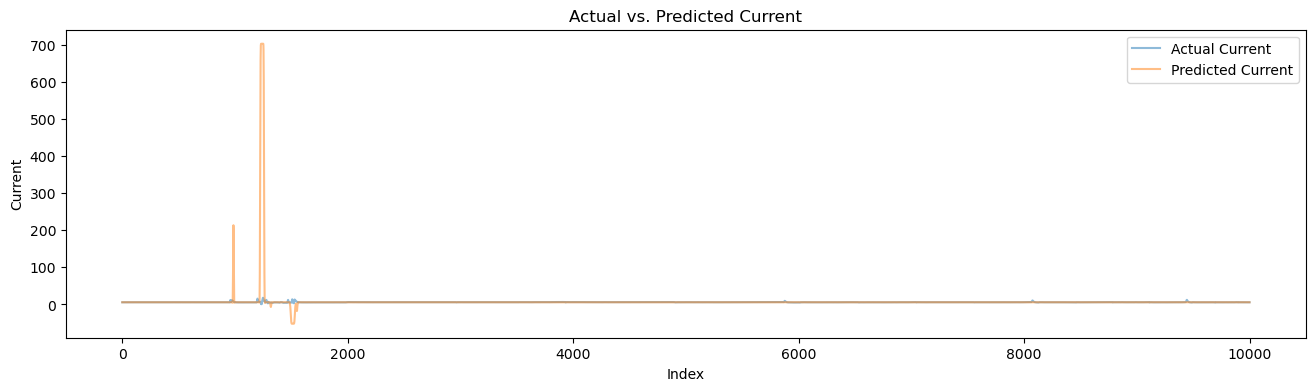

In [26]:
neural_nets(X_train_non_peak_f1, X_test_non_peak_f1, y_train_non_peak_f1, y_test_non_peak_f1)

Mean Absolute Error: 0.3777947549893462
Mean Squared Error: 0.588090166060659
Root Mean Squared Error: 0.766870371093224
R-squared Score: 0.13102393668697787
Mean Absolute Percentage Error: 6.193026639792974


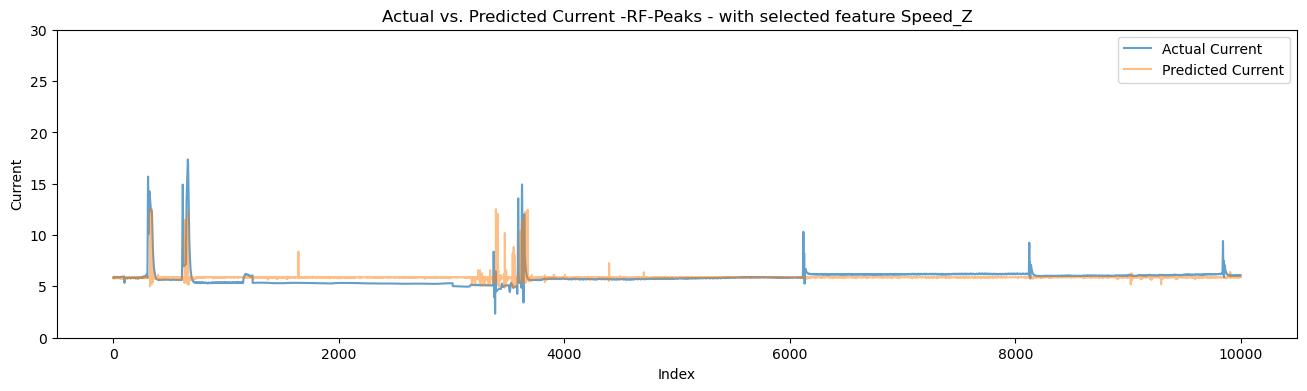

In [59]:
fit_predict(rf_model, X_train_peak_f1, X_test_peak_f1, y_train_peak_f1, y_test_peak_f1, 'RF-Peaks - with selected feature ' + column_name)

Mean Absolute Error: 0.3769960674179936
Mean Squared Error: 0.6413478592909841
Root Mean Squared Error: 0.8008419689870057
R-squared Score: 0.052329098250167516
Mean Absolute Percentage Error: 6.166840765075555


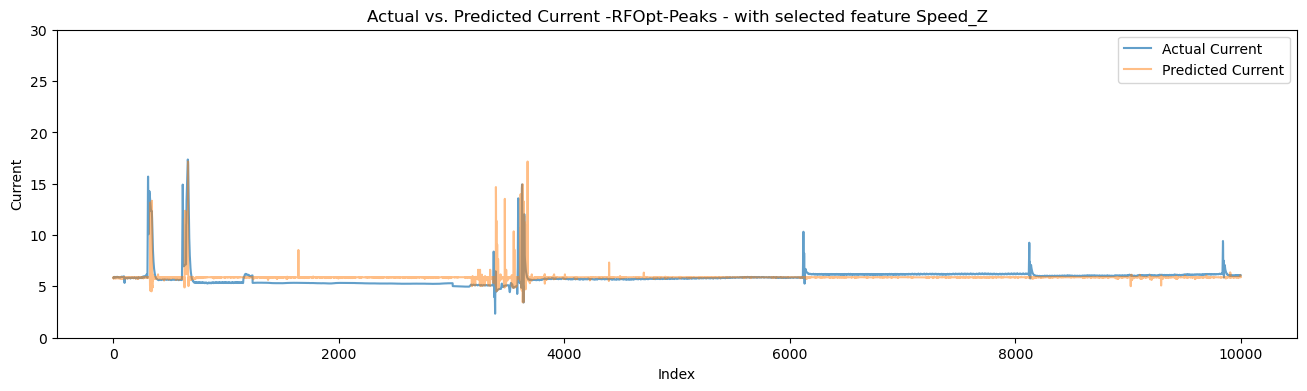

In [60]:
fit_predict(best_grid, X_train_peak_f1, X_test_peak_f1, y_train_peak_f1, y_test_peak_f1, 'RFOpt-Peaks - with selected feature ' + column_name)

d:\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Mean Absolute Error: 0.39766462275282644
Mean Squared Error: 1.1510973250304297
Root Mean Squared Error: 1.0728920379192073
R-squared Score: 0.0478180869829804
Mean Absolute Percentage Error: 6.084954823358763


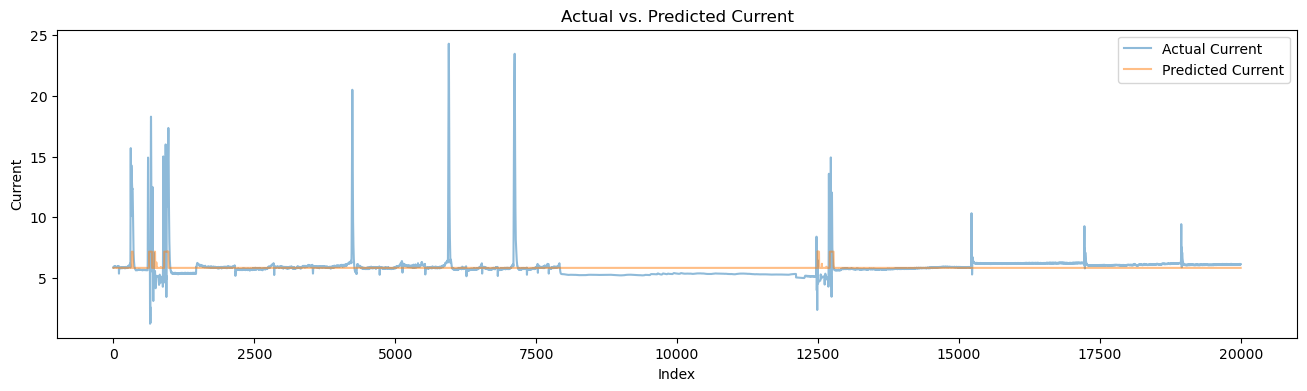

In [28]:
neural_nets(X_train_peak_f1, X_test_peak_f1, y_train_peak_f1, y_test_peak_f1)

| Model                   |  MAE  |  MSE  |  RMSE |   R2  | MAPE  |
|-------------------------|-------|-------|-------|-------|-------|
| General Random Forest   | 0.101 | 0.195 | 0.442 | 0.800 | 1.586 |
| General Neural Network  | 0.269 | 0.782 | 0.884 | 0.199 | 3.975 |
|                         |       |       |       |       |       |
| Global Random Forest    | 0.272 | 0.572 | 0.756 | -0.20 | 4.059 |
|  Global Neural Network  | 3.020 | 1561. | 39.51 | -3292 | 62.84 |
|                         |       |       |       |       |       |
| Peak-Aware RF           | 0.395 | 1.136 | 1.066 | 0.059 | 6.114 |
|  Peak-Aware NN          | 0.397 | 1.151 | 1.072 | 0.047 | 6.084 |

## Using Speed_X

In [61]:
X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak = create_train_test_split(X_train, y_train, X_test, y_test, 'Speed_X')

Mean Absolute Error: 0.2775508033480573
Mean Squared Error: 0.5379581084507616
Root Mean Squared Error: 0.7334562757593405
R-squared Score: 0.1704394553600923
Mean Absolute Percentage Error: 4.535492285455888


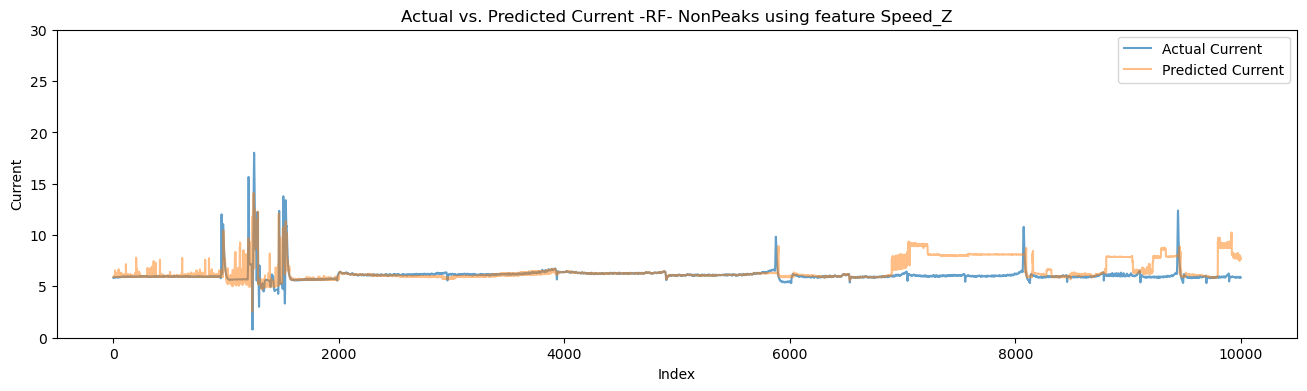

In [62]:
fit_predict(rf_model, X_train_non_peak, X_test_non_peak, y_train_non_peak, y_test_non_peak, 'RF- NonPeaks using feature ' + column_name)

Mean Absolute Error: 0.18874170036694313
Mean Squared Error: 0.3284603155968579
Root Mean Squared Error: 0.5731145745807359
R-squared Score: 0.49349640052118515
Mean Absolute Percentage Error: 2.9861187290481017


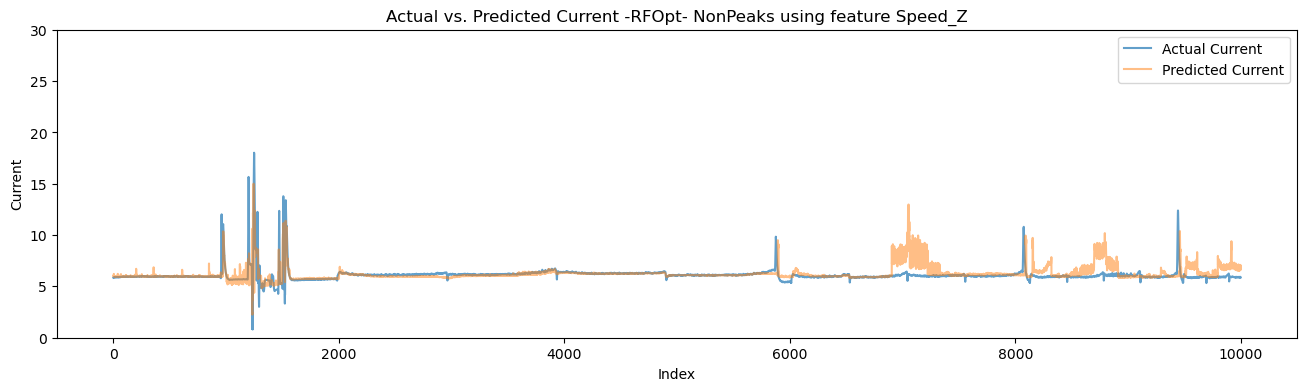

In [64]:
fit_predict(best_grid, X_train_non_peak, X_test_non_peak, y_train_non_peak, y_test_non_peak, 'RFOpt- NonPeaks using feature ' + column_name)

Mean Absolute Error: 0.150483247462826
Mean Squared Error: 0.361281602766074
Root Mean Squared Error: 0.60106705346914
R-squared Score: 0.810858348925242
Mean Absolute Percentage Error: 2.39881690725001


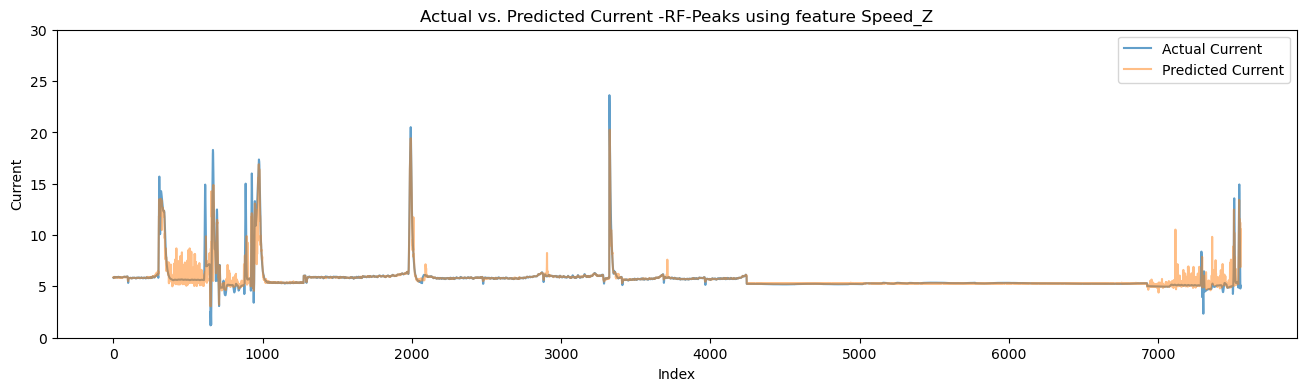

In [63]:
fit_predict(rf_model, X_train_peak, X_test_peak, y_train_peak, y_test_peak, 'RF-Peaks using feature ' + column_name)

Mean Absolute Error: 0.14893404624604192
Mean Squared Error: 0.3504199651697649
Root Mean Squared Error: 0.5919628072520814
R-squared Score: 0.8165447388565659
Mean Absolute Percentage Error: 2.3320353593146668


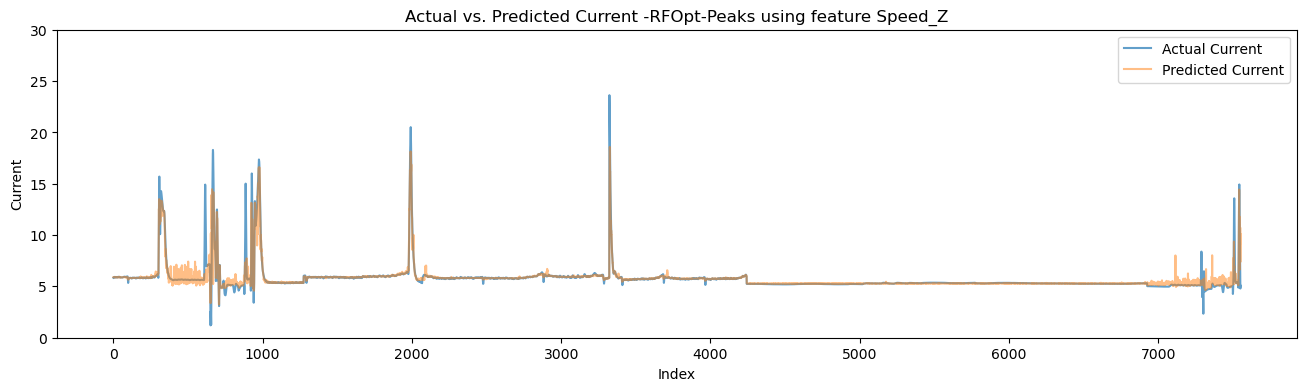

In [65]:
fit_predict(best_grid, X_train_peak, X_test_peak, y_train_peak, y_test_peak, 'RFOpt-Peaks using feature ' + column_name)

Peak-Aware RF model based on feature 'Speed_X'

| Model                   |  MAE  |  MSE  |  RMSE |   R2  | MAPE  |
|-------------------------|-------|-------|-------|-------|-------|
| General Random Forest   | 0.101 | 0.195 | 0.442 | 0.800 | 1.586 |
| General Neural Network  | 0.269 | 0.782 | 0.884 | 0.199 | 3.975 |
|                         |       |       |       |       |       |
| Peak-Aware RF Peaks     | 1.828 | 6.580 | 2.565 | 0.436 | 28.18 |
| Peak-Aware RF Non-Peaks | 0.100 | 0.194 | 0.441 | 0.798 | 1.557 |

## Using Accel_SP

In [67]:
X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak = create_train_test_split(X_train, y_train, X_test, y_test, 'Accel_SP')

Mean Absolute Error: 0.08656710720092725
Mean Squared Error: 0.17660227450618554
Root Mean Squared Error: 0.42024073399206024
R-squared Score: 0.7466576892008963
Mean Absolute Percentage Error: 1.320352257458126


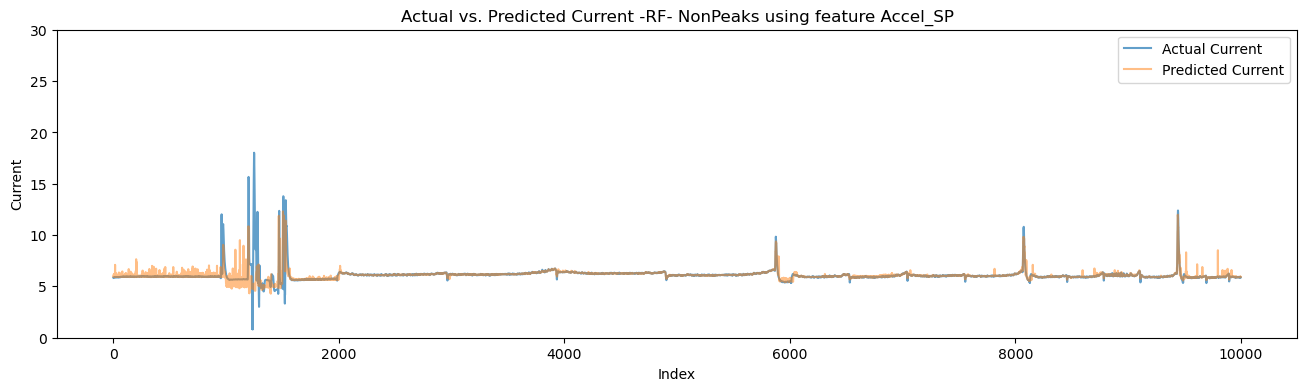

In [68]:
fit_predict(rf_model, X_train_non_peak, X_test_non_peak, y_train_non_peak, y_test_non_peak, 'RF- NonPeaks using feature Accel_SP')

Mean Absolute Error: 0.09941362007419137
Mean Squared Error: 0.20639821645149609
Root Mean Squared Error: 0.4543107047511605
R-squared Score: 0.7039143394565728
Mean Absolute Percentage Error: 1.4783109240041012


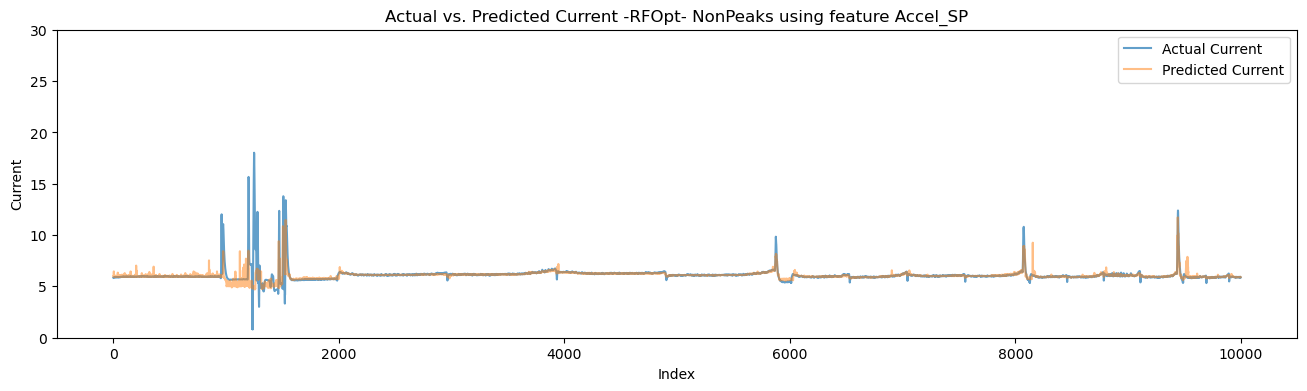

In [69]:
fit_predict(best_grid, X_train_non_peak, X_test_non_peak, y_train_non_peak, y_test_non_peak, 'RFOpt- NonPeaks using feature Accel_SP')

Mean Absolute Error: 0.7016972486181142
Mean Squared Error: 2.3079026184173586
Root Mean Squared Error: 1.5191782707823853
R-squared Score: 0.7042122829304325
Mean Absolute Percentage Error: 10.351568383633353


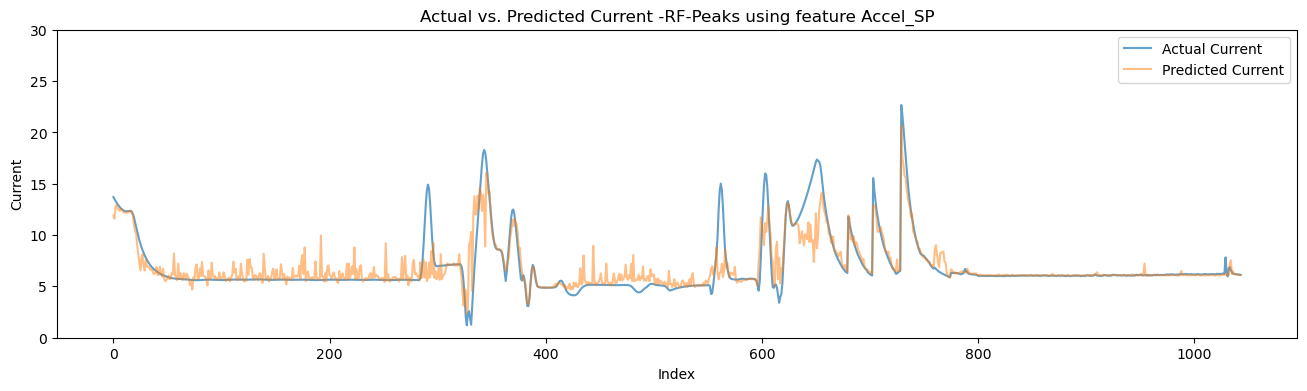

In [70]:
fit_predict(rf_model, X_train_peak, X_test_peak, y_train_peak, y_test_peak, 'RF-Peaks using feature Accel_SP')

Mean Absolute Error: 0.6466597803549067
Mean Squared Error: 2.27040355125684
Root Mean Squared Error: 1.5067858345686822
R-squared Score: 0.7090182757739496
Mean Absolute Percentage Error: 9.43901414471654


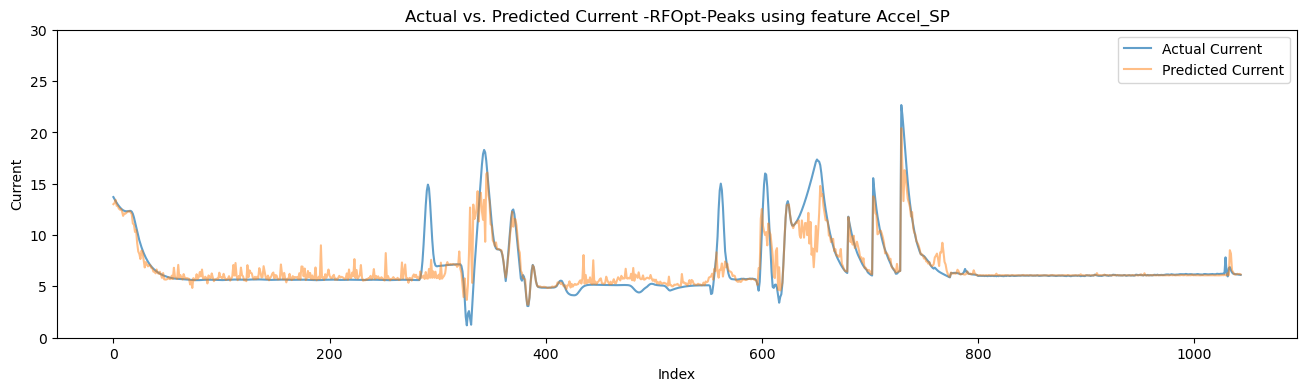

In [71]:
fit_predict(best_grid, X_train_peak, X_test_peak, y_train_peak, y_test_peak, 'RFOpt-Peaks using feature Accel_SP')

RF for Peaks and NonPeaks using the feature 'Accel_SP'

| Model           |  MAE  |  MSE  |  RMSE |   R2  | MAPE  |
|-----------------|-------|-------|-------|-------|-------|
| RF Peak         | 0.190 | 0.323 | 0.568 | 0.722 | 3.082 |
| RF Non-Peak     | 0.094 | 0.183 | 0.428 | 0.801 | 1.470 |


# Investigation

In [11]:
def plot_feature(x, title):
    plt.figure(figsize=(16, 4))
    x_values = np.arange(50000)
    plt.plot(x_values, x[:50000])
    plt.ylim(-5, 5)  # Set y-axis limits from 0 to 30
    plt.xlabel('Index')
    plt.ylabel(title)
    plt.title('Plot of feature - ' + title)
    plt.show()

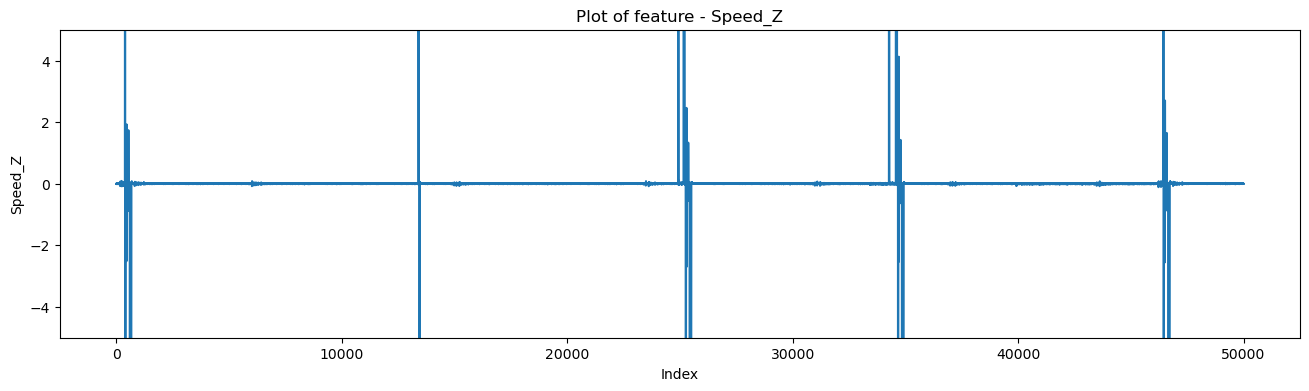

In [12]:
plot_feature(df['Speed_Z'], 'Speed_Z')

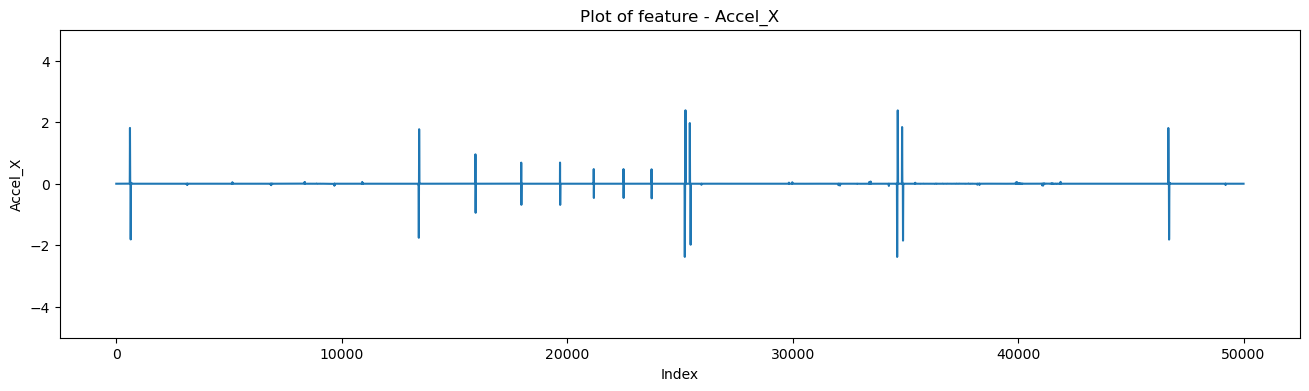

In [13]:
plot_feature(df['Accel_X'], 'Accel_X')

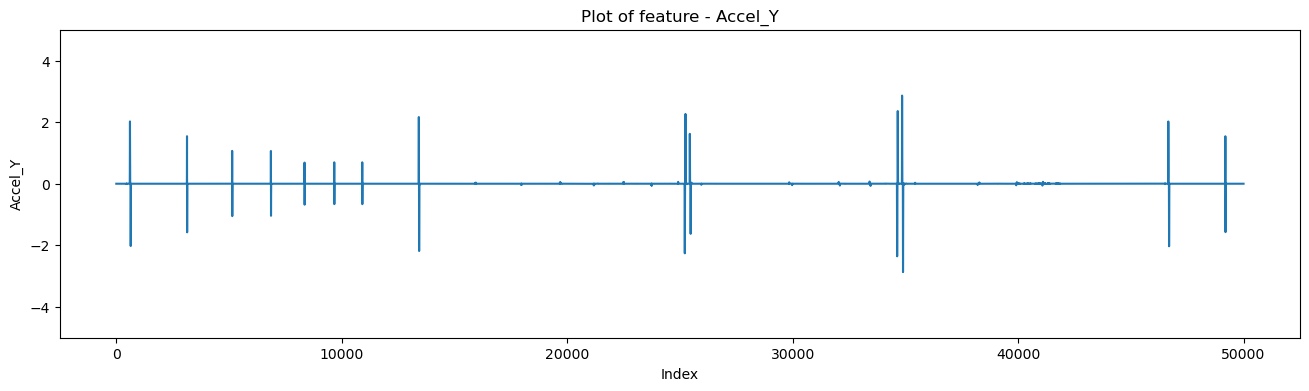

In [14]:
plot_feature(df['Accel_Y'], 'Accel_Y')

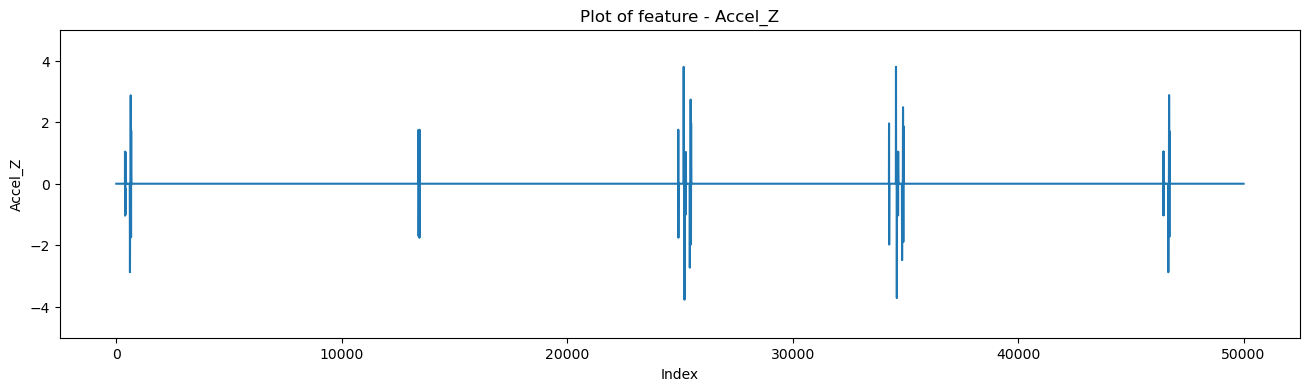

In [15]:
plot_feature(df['Accel_Z'], 'Accel_Z')

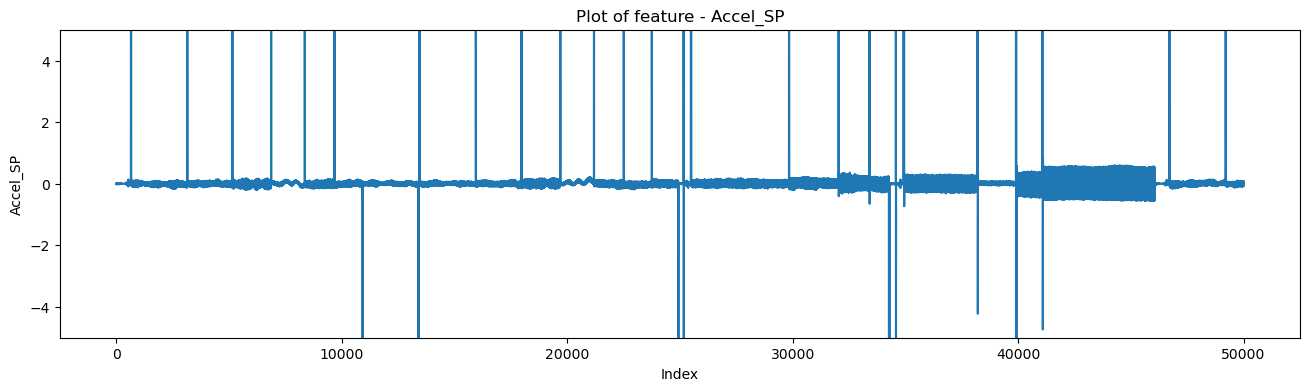

In [16]:
plot_feature(df['Accel_SP'], 'Accel_SP')